In [1]:
##########################################################################
# Created on Mon Jun 21 20:15:13 2020                                    #
# Knowledge Transfer for MUMSS Project [VaR]                             #
# @author: Meng Lipeng (FRM, CFA)                                        #
##########################################################################

# Value at Risk

## 1.VaR Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
a = 0.95 #95% Confidence level
z = st.norm.ppf(q=1-a) #Percent Point Function
x = np.linspace(-4,4,200)
y = st.norm.pdf(x) #Probability Density Function
x1 = np.linspace(-4,z,100)
y1 = st.norm.pdf(x1)

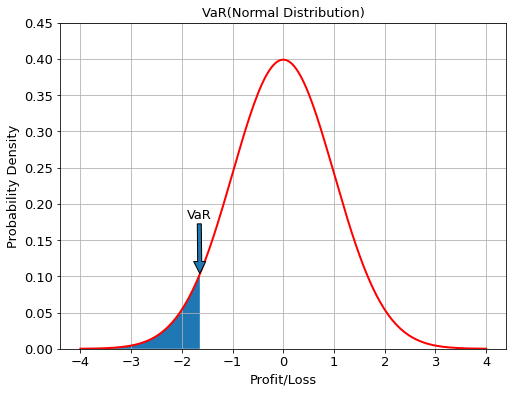

In [3]:
plt.figure(figsize=(8,6))
plt.plot(x,y,'r-',lw=2.0)
plt.fill_between(x1,y1) #Plot dash area
plt.xlabel('Profit/Loss',fontsize=13)
plt.ylabel('Probability Density',fontsize=13,rotation='vertical')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,0.45)
plt.annotate('VaR', xy=(z, st.norm.pdf(z)),xytext=(-1.9,0.18),arrowprops=dict(shrink=0.01),fontsize=13)
plt.title('VaR(Normal Distribution)',fontsize=13)
plt.grid('True')
plt.show()

## 2.VaR Measurement

#### Get Data from Yahoo finance

In [4]:
import pandas_datareader.data as web
import datetime
import pandas as pd

In [34]:
enddate = datetime.datetime.now()
offset = datetime.timedelta(days = -365*5)
begdate = enddate + offset

In [35]:
ticker = ["ACN", "AAPL", "WMT", "GS", "XOM"]

for i in range(len(ticker)):
    df = web.get_data_yahoo(ticker[i],begdate,enddate)
    df.columns = [ticker[i] + '_High', ticker[i] + '_Low', ticker[i] + '_Open', ticker[i] + '_Close', ticker[i] + '_Volumn', ticker[i]]
    if i == 0:
        result = df[ticker[i]]
    else:
        result = pd.concat([result, df[ticker[i]]], axis=1, join='inner')
        
result.head()

,ACN,AAPL,WMT,GS,XOM
Date,,,,,
2016-10-24,107.047676,27.584234,62.326038,160.747208,67.231979
2016-10-25,106.557732,27.724911,62.479187,161.141937,67.084991
2016-10-26,106.724121,27.101238,62.686356,162.537140,67.371208
2016-10-27,106.733383,26.840994,62.902573,163.161331,67.239708
2016-10-28,106.927513,26.662807,63.046688,162.601425,65.584229


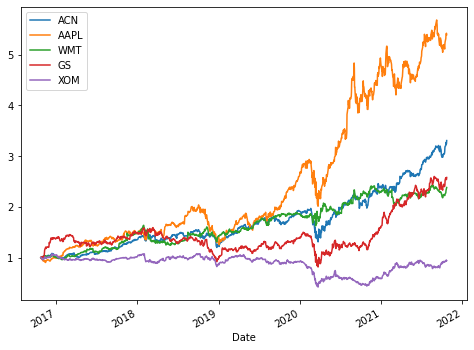

In [36]:
# Set the stock price of first day to 1 and plot
(result / result.iloc[0]).plot(figsize = (8, 6))

#### Calculate the daily return

In [37]:
R = np.log(result / result.shift(1)) #time series of log return
R = R.dropna() # drop the NA from result
R.describe()

,ACN,AAPL,WMT,GS,XOM
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.000950,0.001339,0.000689,0.000753,-0.000050
std,0.015593,0.019051,0.013620,0.019920,0.018996
min,-0.087629,-0.137708,-0.107399,-0.135881,-0.130391
25%,-0.005172,-0.006525,-0.005284,-0.008324,-0.008333
50%,0.001710,0.001188,0.000668,0.000588,-0.000131
75%,0.008037,0.010454,0.006567,0.010435,0.007905
max,0.120954,0.113157,0.110723,0.161951,0.119442


#### Calculate statistics of daily return

In [38]:
R_mean = R.mean()
print(R_mean)

ACN     0.000950
AAPL    0.001339
WMT     0.000689
GS      0.000753
XOM    -0.000050
dtype: float64


In [39]:
R_vol = R.std()
print(R_vol)

ACN     0.015593
AAPL    0.019051
WMT     0.013620
GS      0.019920
XOM     0.018996
dtype: float64


In [40]:
R_cov = R.cov()
print(R_cov)

           ACN      AAPL       WMT        GS       XOM
ACN   0.000243  0.000175  0.000081  0.000180  0.000147
AAPL  0.000175  0.000363  0.000096  0.000188  0.000132
WMT   0.000081  0.000096  0.000186  0.000077  0.000059
GS    0.000180  0.000188  0.000077  0.000397  0.000236
XOM   0.000147  0.000132  0.000059  0.000236  0.000361


In [41]:
R_corr = R.corr()
print(R_corr)

           ACN      AAPL       WMT        GS       XOM
ACN   1.000000  0.587884  0.382255  0.579104  0.496013
AAPL  0.587884  1.000000  0.370396  0.495116  0.365284
WMT   0.382255  0.370396  1.000000  0.285555  0.227403
GS    0.579104  0.495116  0.285555  1.000000  0.622834
XOM   0.496013  0.365284  0.227403  0.622834  1.000000


#### Calculate portfolio return and volatility

In [42]:
weights = np.array([0.4,0.15,0.2,0.1,0.15]) #Hypothetic weights of today
Rp_daily = np.sum(weights*R_mean)
Vp_daily = np.sqrt(np.dot(weights,np.dot(R_cov,weights.T)))
print('Daily mean return of portfolio',round(Rp_daily,6))
print('Daily volatility of portfolio', round(Vp_daily,6))

Daily mean return of portfolio 0.000787
Daily volatility of portfolio 0.012791


### 2.1.Variance-Covariance Method

In [43]:
def VaR_VCM(Value, Rp, Vp, X, N):
    '''Variance-Convariance Method to Calculate VaR
    Value: Value of portfolio
    Rp: Daily mean return of portfolio
    Vp: Daily volatility of portfolio
    X: Confidence level
    N: (days)Time horizon'''
    z = np.abs(st.norm.ppf(q=1-X))
    return np.sqrt(N)*Value*(z*Vp-Rp)

In [44]:
Value_port = 100000000 #Hypothetic value of today
VaR99_1day_VCM = VaR_VCM(Value_port, Rp_daily, Vp_daily, 0.99, 1)
VaR95_1day_VCM = VaR_VCM(Value_port, Rp_daily, Vp_daily, 0.95, 1)
VaR99_10day_VCM = VaR_VCM(Value_port, Rp_daily, Vp_daily, 0.99, 10)
VaR95_10day_VCM = VaR_VCM(Value_port, Rp_daily, Vp_daily, 0.95, 10)

print('1day 99VaR: ',f"{VaR99_1day_VCM:,.2f}")
print('1day 95VaR: ',f"{VaR95_1day_VCM:,.2f}")
print('10day 99VaR: ',f"{VaR99_10day_VCM:,.2f}")
print('10day 95VaR: ',f"{VaR95_10day_VCM:,.2f}")

1day 99VaR:  2,896,863.89
1day 95VaR:  2,025,197.05
10day 99VaR:  9,160,687.98
10day 95VaR:  6,404,235.39


### 2.2.Historical Method

#### Plot historical return

In [45]:
Value_asset = Value_port * weights #value of every asset

In [46]:
Return_history = np.dot(R, Value_asset)
Return_history = pd.DataFrame(Return_history, index=R.index, columns=['Historical_Simulation_Return'])

In [47]:
Return_history.describe()

,Historical_Simulation_Return
count,1.258000e+03
mean,7.865691e+04
std,1.279052e+06
min,-9.769826e+06
25%,-3.590730e+05
50%,7.159777e+04
75%,6.517095e+05
max,9.043229e+06


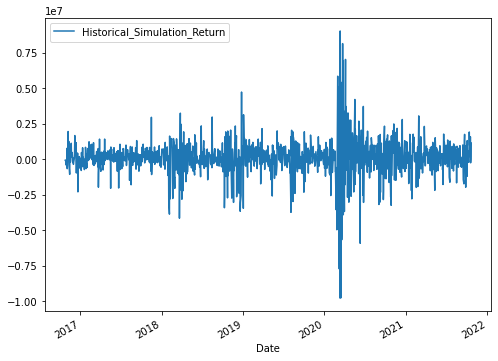

In [48]:
Return_history.plot(figsize=(8,6))

#### Normality tests

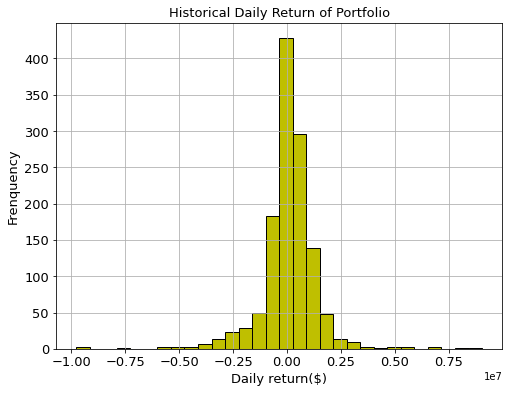

In [49]:
plt.figure(figsize=(8,6))
plt.hist(np.array(Return_history),bins=30,facecolor='y',edgecolor='k')
plt.xticks(fontsize=13)
plt.xlabel('Daily return($)',fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Frenquency',fontsize=13,rotation='vertical')
plt.title('Historical Daily Return of Portfolio',fontsize=13)
plt.grid('True')
plt.show()

In [50]:
# Normarity Kolmogorov-Smirnov Tests
# H0:Normarity H1:No normarity
st.kstest(rvs=Return_history['Historical_Simulation_Return'],cdf='norm')

KstestResult(statistic=0.5532591414944357, pvalue=0.0)

In [51]:
# Normarity Anderson-Darling Tests
# H0:Normarity H1:No normarity
st.anderson(x=Return_history['Historical_Simulation_Return'],dist='norm')

AndersonResult(statistic=40.87136329584882, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [52]:
# Normarity Shapiro-Wilk Tests
# H0:Normarity H1:No normarity
st.shapiro(Return_history['Historical_Simulation_Return'])

ShapiroResult(statistic=0.8463289141654968, pvalue=3.0795749776346064e-33)

In [53]:
# NormalTest
# H0:Normarity H1:No normarity
st.normaltest(Return_history['Historical_Simulation_Return'])

NormaltestResult(statistic=309.66292284637234, pvalue=5.722037226200062e-68)

#### Calculate historical VaR

In [54]:
def VaR_History(S, W, R, X, N):
    '''Historical Simulation Method to Calculate VaR
    S: Value of portfolio
    W: Weight of every asset in portfolio
    R: Daily return of asset in portfolio
    X: Confidence level
    N: (days)Time horizon'''
    Value_assets = S * W #value of every asset
    Return_history=np.dot(R,Value_assets)
    
    VaR_1day = np.abs(np.percentile(a=Return_history,q=(1-X)*100))
    VaR_Ndays = np.sqrt(N)*VaR_1day
    
    return VaR_Ndays

In [55]:
VaR99_1day_HM = VaR_History(Value_port, weights, R, 0.99, 1)
VaR95_1day_HM = VaR_History(Value_port, weights, R, 0.95, 1)
VaR99_10day_HM = VaR_History(Value_port, weights, R, 0.99, 10)
VaR95_10day_HM = VaR_History(Value_port, weights, R, 0.95, 10)

print('1day 99VaR: ',f"{VaR99_1day_HM:,.2f}")
print('1day 95VaR: ',f"{VaR95_1day_HM:,.2f}")
print('10day 99VaR: ',f"{VaR99_10day_HM:,.2f}")
print('10day 95VaR: ',f"{VaR95_10day_HM:,.2f}")

1day 99VaR:  3,665,311.21
1day 95VaR:  1,965,924.82
10day 99VaR:  11,590,731.77
10day 95VaR:  6,216,800.13


### 2.3.Monte Carlo Simulation Method

#### Stochastic Process

The price of financial assets follows a stochastic process.

$\large S_{t}=S_{t-\Delta t}e^{\left(\mu-\frac{1}{2}\sigma^{2}\right)\Delta t+\sigma \epsilon_{t}\sqrt{\Delta t}}$

$\large Assume \space\epsilon_{t}\space follows\space students\space t\space distribution\space or\space normal\space distribution$

In [56]:
def VaR_MCSM(S, P, W, R, X, N, I, D):
    '''Monte-Carlo Simulation Method to Calculate VaR
    S: Value of portfolio
    P: Price of every asset in portfolio
    W: Weight of every asset in portfolio
    R: Daily return of asset in portfolio
    X: Confidence level
    N: (days)Time horizon
    I: Times of simulation
    D: Distribution(t:Students t, n:Normal)'''
    import numpy.random as npr
    
    R_mean = R.mean()*252 #annual return
    R_vol = R.std()*np.sqrt(252) #annual volatility
    dt = 1/252
    N_assets=len(R.columns)
    if D=='n':
        epsilon=npr.standard_normal(size=I)
    elif D=='t':
        epsilon=npr.standard_t(df=len(R),size=I)
    else:
        print('Not implemented!!!')
        return
    
    #Calculate price of next day
    P_new = np.zeros(shape=(I,N_assets))
    for i in range(N_assets):
        P_new[:,i]=P[i]*np.exp((R_mean[i]-0.5*R_vol[i]**2)*dt+R_vol[i]*epsilon*np.sqrt(dt))
    
    S_delta=(np.dot(P_new/(P.T)-1,W))*S
    
    #Plot
    plt.figure(figsize=(8,6))
    plt.hist(S_delta,bins=30,facecolor='y',edgecolor='k')
    plt.xticks(fontsize=13)
    plt.xlabel('Simulated daily return($)',fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Frenquency',fontsize=13,rotation='vertical')
    plt.title('Monte Carlo Simulated Daily Return of Portfolio',fontsize=13)
    plt.grid('True')
    plt.show()
    
    #Calculate VaR
    VaR_1day = np.abs(np.percentile(a=S_delta,q=(1-X)*100))
    VaR_Ndays = np.sqrt(N)*VaR_1day
    
    return VaR_Ndays

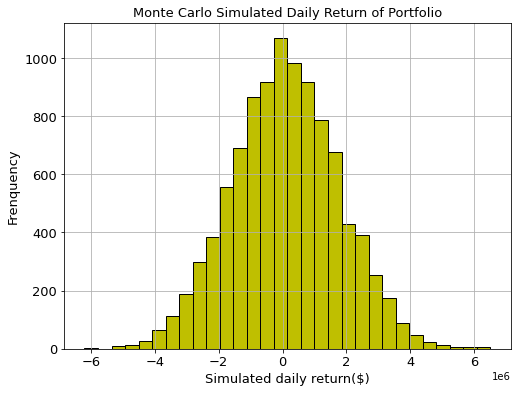

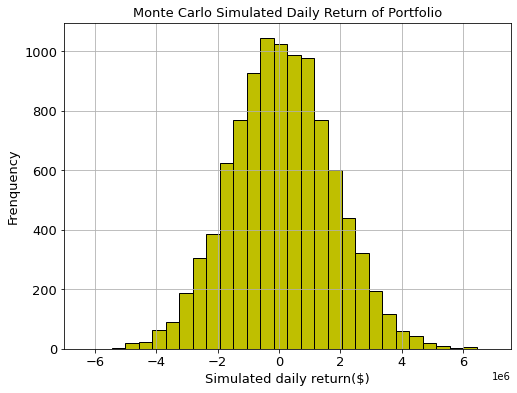

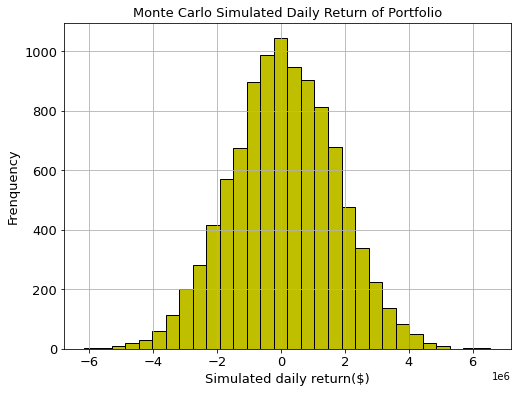

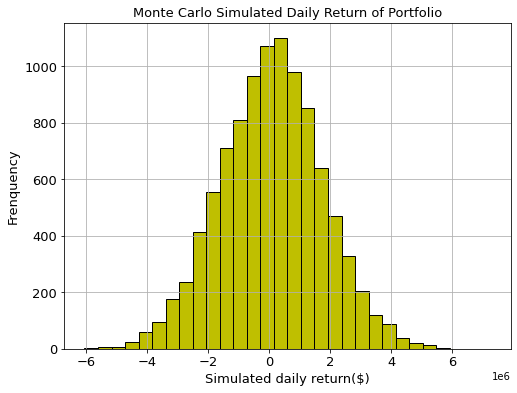

1day 99VaR:  3,749,648.30
1day 95VaR:  2,603,002.57
10day 99VaR:  11,785,450.56
10day 95VaR:  8,469,209.23


In [57]:
Price_end = np.array(result.iloc[-1])
#Assume Student-t distribution
VaR99_1day_MCSM_t = VaR_MCSM(Value_port, Price_end, weights, R, 0.99, 1, 10000, 't')
VaR95_1day_MCSM_t = VaR_MCSM(Value_port, Price_end, weights, R, 0.95, 1, 10000, 't')
VaR99_10day_MCSM_t = VaR_MCSM(Value_port, Price_end, weights, R, 0.99, 10, 10000, 't')
VaR95_10day_MCSM_t = VaR_MCSM(Value_port, Price_end, weights, R, 0.95, 10, 10000, 't')

print('1day 99VaR: ',f"{VaR99_1day_MCSM_t:,.2f}")
print('1day 95VaR: ',f"{VaR95_1day_MCSM_t:,.2f}")
print('10day 99VaR: ',f"{VaR99_10day_MCSM_t:,.2f}")
print('10day 95VaR: ',f"{VaR95_10day_MCSM_t:,.2f}")

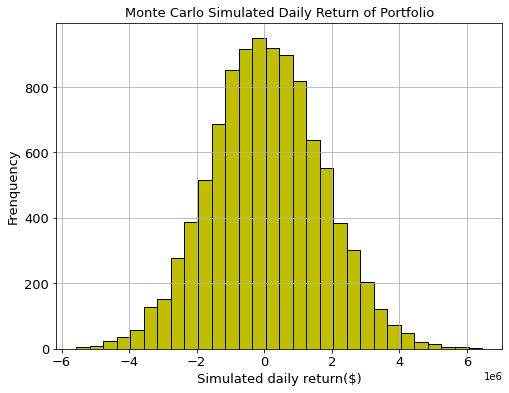

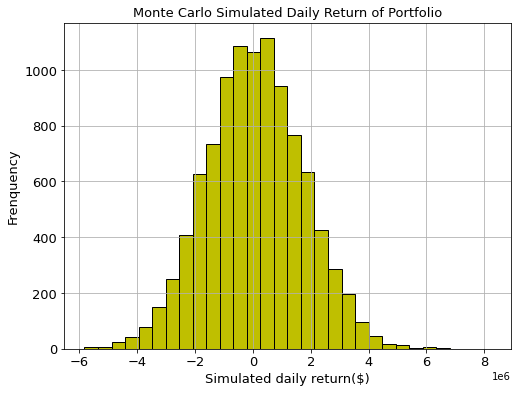

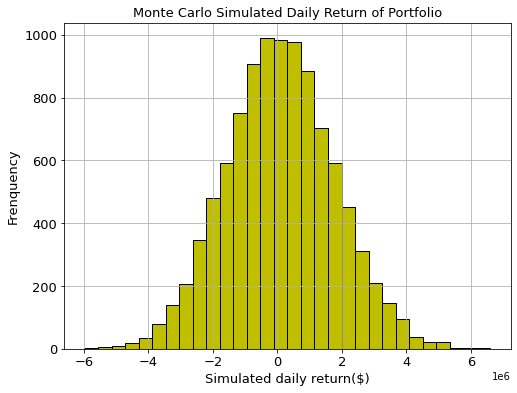

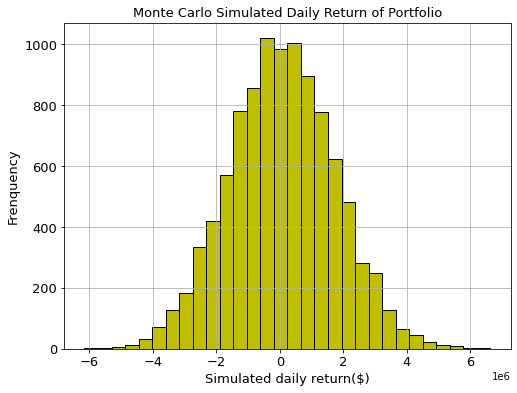

1day 99VaR:  3,720,142.77
1day 95VaR:  2,635,722.31
10day 99VaR:  11,835,430.59
10day 95VaR:  8,399,815.69


In [58]:
#Assume Normal Distribution
VaR99_1day_MCSM_n = VaR_MCSM(Value_port, Price_end, weights, R, 0.99, 1, 10000, 'n')
VaR95_1day_MCSM_n = VaR_MCSM(Value_port, Price_end, weights, R, 0.95, 1, 10000, 'n')
VaR99_10day_MCSM_n = VaR_MCSM(Value_port, Price_end, weights, R, 0.99, 10, 10000, 'n')
VaR95_10day_MCSM_n = VaR_MCSM(Value_port, Price_end, weights, R, 0.95, 10, 10000, 'n')

print('1day 99VaR: ',f"{VaR99_1day_MCSM_n:,.2f}")
print('1day 95VaR: ',f"{VaR95_1day_MCSM_n:,.2f}")
print('10day 99VaR: ',f"{VaR99_10day_MCSM_n:,.2f}")
print('10day 95VaR: ',f"{VaR95_10day_MCSM_n:,.2f}")

## 3.Back Testing and Stress Testing

### 3.1.Back Testing

In [59]:
#Time series of daily return
Return_2016 = Return_history.loc['2016-01-01':'2016-12-31']
Return_2017 = Return_history.loc['2017-01-01':'2017-12-31']
Return_2018 = Return_history.loc['2018-01-01':'2018-12-31']
Return_2019 = Return_history.loc['2019-01-01':'2019-12-31']
Return_2020 = Return_history.loc['2020-01-01':'2020-12-31']

days_2016 = len(Return_2016)
days_2017 = len(Return_2017)
days_2018 = len(Return_2018)
days_2019 = len(Return_2019)
days_2020 = len(Return_2020)

print('Trading days of 2016: ',days_2016)
print('Trading days of 2017: ',days_2017)
print('Trading days of 2018: ',days_2018)
print('Trading days of 2019: ',days_2019)
print('Trading days of 2020: ',days_2020)

Trading days of 2016:  47
Trading days of 2017:  251
Trading days of 2018:  251
Trading days of 2019:  252
Trading days of 2020:  253


In [60]:
VaR_2016 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2016), index=Return_2016.index)
VaR_2017 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2017), index=Return_2017.index)
VaR_2018 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2018), index=Return_2018.index)
VaR_2019 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2019), index=Return_2019.index)
VaR_2020 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2020), index=Return_2020.index)

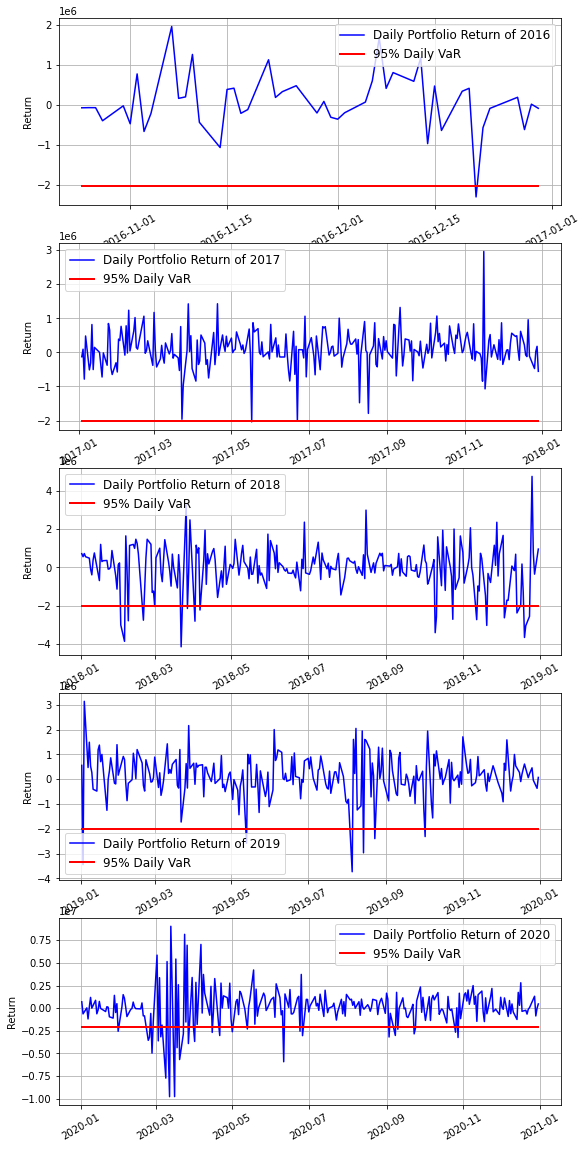

In [61]:
plt.figure(figsize=(9,20))
plt.subplot(5,1,1)
plt.plot(Return_2016,'b-',label='Daily Portfolio Return of 2016')
plt.plot(VaR_2016,'r-',label='95% Daily VaR',lw=2.0)
plt.ylabel('Return',rotation='vertical')
plt.xticks(rotation=30)
plt.legend(fontsize=12)
plt.grid('True')

plt.subplot(5,1,2)
plt.plot(Return_2017,'b-',label='Daily Portfolio Return of 2017')
plt.plot(VaR_2017,'r-',label='95% Daily VaR',lw=2.0)
plt.ylabel('Return',rotation='vertical')
plt.xticks(rotation=30)
plt.legend(fontsize=12)
plt.grid('True')

plt.subplot(5,1,3)
plt.plot(Return_2018,'b-',label='Daily Portfolio Return of 2018')
plt.plot(VaR_2018,'r-',label='95% Daily VaR',lw=2.0)
plt.ylabel('Return',rotation='vertical')
plt.xticks(rotation=30)
plt.legend(fontsize=12)
plt.grid('True')

plt.subplot(5,1,4)
plt.plot(Return_2019,'b-',label='Daily Portfolio Return of 2019')
plt.plot(VaR_2019,'r-',label='95% Daily VaR',lw=2.0)
plt.ylabel('Return',rotation='vertical')
plt.xticks(rotation=30)
plt.legend(fontsize=12)
plt.grid('True')

plt.subplot(5,1,5)
plt.plot(Return_2020,'b-',label='Daily Portfolio Return of 2020')
plt.plot(VaR_2020,'r-',label='95% Daily VaR',lw=2.0)
plt.ylabel('Return',rotation='vertical')
plt.xticks(rotation=30)
plt.legend(fontsize=12)
plt.grid('True')

plt.show()

In [62]:
day_except2016 = len(Return_2016[Return_2016['Historical_Simulation_Return']< -VaR95_1day_VCM])
day_except2017 = len(Return_2017[Return_2017['Historical_Simulation_Return']< -VaR95_1day_VCM])
day_except2018 = len(Return_2018[Return_2018['Historical_Simulation_Return']< -VaR95_1day_VCM])
day_except2019 = len(Return_2019[Return_2019['Historical_Simulation_Return']< -VaR95_1day_VCM])
day_except2020 = len(Return_2020[Return_2020['Historical_Simulation_Return']< -VaR95_1day_VCM])

print('Days exceeding VaR in 2016: ', day_except2016)
print('Ratio of exceeding VaR in 2016: ', round(day_except2016 / days_2016,4))
print('Days exceeding VaR in 2017: ', day_except2017)
print('Ratio of exceeding VaR in 2017: ', round(day_except2017 / days_2017,4))
print('Days exceeding VaR in 2018: ', day_except2018)
print('Ratio of exceeding VaR in 2018: ', round(day_except2018 / days_2018,4))
print('Days exceeding VaR in 2019: ', day_except2019)
print('Ratio of exceeding VaR in 2019: ', round(day_except2019 / days_2019,4))
print('Days exceeding VaR in 2020: ', day_except2020)
print('Ratio of exceeding VaR in 2020: ', round(day_except2020 / days_2020,4))

Days exceeding VaR in 2016:  1
Ratio of exceeding VaR in 2016:  0.0213
Days exceeding VaR in 2017:  1
Ratio of exceeding VaR in 2017:  0.004
Days exceeding VaR in 2018:  19
Ratio of exceeding VaR in 2018:  0.0757
Days exceeding VaR in 2019:  6
Ratio of exceeding VaR in 2019:  0.0238
Days exceeding VaR in 2020:  29
Ratio of exceeding VaR in 2020:  0.1146


### 3.2.Stress Testing

#### Stress Scenario:2020/02/21~2020/03/23 COVID-19

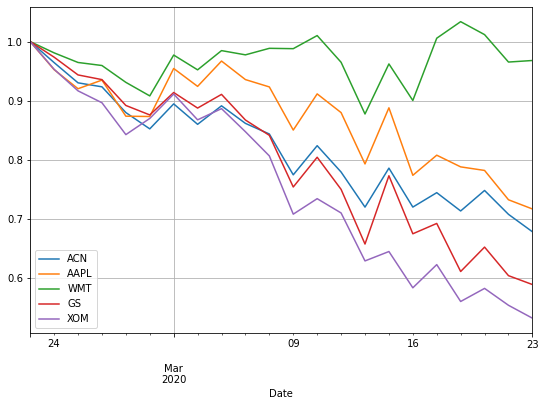

In [35]:
price_stress=result.loc['2020-02-21':'2020-03-23']
(price_stress/price_stress.iloc[0]).plot(figsize=(9,6),grid=True)

In [36]:
return_stress=Return_history.loc['2020-02-21':'2020-03-23']
return_stress.describe()

,Historical_Simulation_Return
count,2.200000e+01
mean,-1.672483e+06
std,5.065774e+06
min,-9.769825e+06
25%,-4.744943e+06
50%,-2.993876e+06
75%,1.798497e+06
max,9.043234e+06


In [37]:
return_zero = pd.DataFrame(np.zeros_like(return_stress),index=return_stress.index)

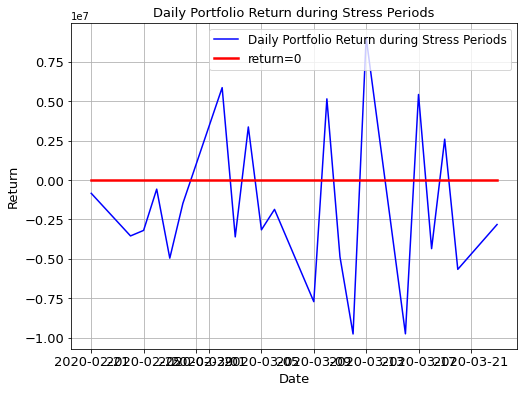

In [38]:
plt.figure(figsize=(8,6))
plt.plot(return_stress,'b-',label='Daily Portfolio Return during Stress Periods')
plt.plot(return_zero,'r-',label='return=0',lw=2.5)
plt.xlabel('Date',fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel('Return',fontsize=13,rotation='vertical')
plt.yticks(fontsize=13)
plt.title('Daily Portfolio Return during Stress Periods', fontsize=13)
plt.legend(fontsize=12)
plt.grid('True')

In [39]:
asset_return_stress = np.log(price_stress/price_stress.shift(1)).dropna()
SVaR99_1day = VaR_History(Value_port, weights, asset_return_stress, 0.99, 1)
SVaR95_1day = VaR_History(Value_port, weights, asset_return_stress, 0.95, 1)
SVaR99_10day = VaR_History(Value_port, weights, asset_return_stress, 0.99, 10)
SVaR95_10day = VaR_History(Value_port, weights, asset_return_stress, 0.95, 10)

print('1day 99 Stress VaR: ',f"{SVaR99_1day:,.2f}")
print('1day 95 Stress VaR: ',f"{SVaR95_1day:,.2f}")
print('10day 99 Stress VaR: ',f"{SVaR99_10day:,.2f}")
print('10day 95 Stress VaR: ',f"{SVaR95_10day:,.2f}")

1day 99 Stress VaR:  9,767,949.80
1day 95 Stress VaR:  9,760,449.92
10day 99 Stress VaR:  30,888,969.43
10day 95 Stress VaR:  30,865,252.72


## 4.Summary

In [71]:
summary = np.ones((4,5),dtype=float)

summary[0][0]=round(VaR95_1day_VCM/10000,2)
summary[0][1]=round(VaR95_1day_HM/10000,2)
summary[0][2]=round(VaR95_1day_MCSM_t/10000,2)
summary[0][3]=round(VaR95_1day_MCSM_n/10000,2)
summary[0][4]=round(SVaR95_1day/10000,2)

summary[1][0]=round(VaR99_1day_VCM/10000,2)
summary[1][1]=round(VaR99_1day_HM/10000,2)
summary[1][2]=round(VaR99_1day_MCSM_t/10000,2)
summary[1][3]=round(VaR99_1day_MCSM_n/10000,2)
summary[1][4]=round(SVaR99_1day/10000,2)

summary[2][0]=round(VaR95_10day_VCM/10000,2)
summary[2][1]=round(VaR95_10day_HM/10000,2)
summary[2][2]=round(VaR95_10day_MCSM_t/10000,2)
summary[2][3]=round(VaR95_10day_MCSM_n/10000,2)
summary[2][4]=round(SVaR95_10day/10000,2)

summary[3][0]=round(VaR99_10day_VCM/10000,2)
summary[3][1]=round(VaR99_10day_HM/10000,2)
summary[3][2]=round(VaR99_10day_MCSM_t/10000,2)
summary[3][3]=round(VaR99_10day_MCSM_n/10000,2)
summary[3][4]=round(SVaR99_10day/10000,2)

print(summary)

[[ 211.45  201.78  264.06  270.05  976.04]
 [ 301.41  385.38  388.24  375.73  976.79]
 [ 668.67  638.09  822.52  844.01 3086.53]
 [ 953.13 1218.68 1157.32 1191.25 3088.9 ]]


In [76]:
pd.DataFrame(summary,columns=['MVM','HM','MCSM_t','MCSM_n','Stress'],index=['1d95','1d99','10d95','10d99'])

,MVM,HM,MCSM_t,MCSM_n,Stress
1d95,211.45,201.78,264.06,270.05,976.04
1d99,301.41,385.38,388.24,375.73,976.79
10d95,668.67,638.09,822.52,844.01,3086.53
10d99,953.13,1218.68,1157.32,1191.25,3088.90
